In [204]:
import pandas as pd
import numpy as np
import time

#sklearn
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,roc_curve, auc
from sklearn import feature_selection
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.externals import joblib

#classifiers
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree



#visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
%matplotlib inline

In [3]:
df_processed = pd.read_csv('data/loan_fteng_data_text.csv')

In [4]:
df_processed.shape

(39301, 67)

#### Reading in processed data

In [5]:
#columns in dataset
df_processed.columns

Index(['loan_amnt', 'funded_amnt_inv', 'home_ownership', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'revol_bal', 'loan_status', 'desc_senti_score',
       'bill', 'card', 'consolid', 'credit', 'current', 'debt', 'fund', 'help',
       'interest', 'job', 'loan', 'money', 'month', 'pay', 'payment', 'plan',
       'rate', 'thank', 'time', 'work', 'year', 'zip_median_income', 'zip_pop',
       'per_act_open', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E',
       'grade_F', 'grade_G', 'term_ 36 months', 'term_ 60 months',
       'emp_length', 'int_rate', 'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified',
       'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vaca

In [6]:
#all features
all_features = list(df_processed.columns)

In [7]:
#text tfidf features
tfidf_features = ['bill', 'card', 'consolid', 'credit', 'current', 'debt', 'fund', 'help',
       'interest', 'job', 'loan', 'money', 'month', 'pay', 'payment', 'plan',
       'rate', 'thank', 'time', 'work', 'year']

#### Feature Engineering

In [8]:
#columns to be deleted - simlar to loan amount
del_columns = ['funded_amnt_inv'] + tfidf_features
#del_columns = ['funded_amnt_inv'] 

In [9]:
#Using intution to pick key predictors
predictors_intution = ['home_ownership','verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified','has_delinquent_hist','has_record_hist']

In [10]:
# % and whole numbers that can be standardized
predictors_standardizable = ['loan_amnt','per_act_open','inq_last_6mths','avg_fico','revol_util','revol_bal','dti','years_since_first_credit','int_rate','emp_length','desc_senti_score','zip_median_income', 'zip_pop']

In [11]:
predictors_remaining = [i for i in all_features if i not in predictors_intution and i not in predictors_standardizable and i not in del_columns]

In [12]:
#validating if all columns are there
test = predictors_intution + predictors_standardizable + predictors_remaining
len(test)

45

In [13]:
#full_data

full_df = df_processed.loc[:,test]

#### Train/Test set 

In [14]:
#Creating train/test data
itrain, itest = train_test_split(np.arange(full_df.shape[0]), train_size=0.7)

In [15]:
#creating a mask to identify train/test records across different types of feature selection later.
mask=np.ones(full_df.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [16]:
mask

array([ True,  True,  True, ..., False,  True,  True], dtype=bool)

#### Standardizing Features

In [17]:

for col in predictors_standardizable:
    print(col)
    valstrain=full_df.loc[mask,col]
    valstest=full_df.loc[~mask,col]
    scaler=StandardScaler().fit(valstrain.reshape(-1,1))
    outtrain=scaler.transform(valstrain.reshape(-1,1))
    outtest=scaler.fit_transform(valstest.reshape(-1,1))
    out=np.empty(mask.shape[0])
    out.flat[mask]=outtrain
    out.flat[~mask]=outtest
    full_df[col]=out


loan_amnt
per_act_open
inq_last_6mths
avg_fico
revol_util
revol_bal
dti
years_since_first_credit
int_rate
emp_length
desc_senti_score
zip_median_income
zip_pop


/Users/ajaykliyara/anaconda_py3/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [18]:
full_df.head(2)

,home_ownership,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,has_delinquent_hist,has_record_hist,loan_amnt,per_act_open,inq_last_6mths,avg_fico,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,bankruptcies
0,0,0,0,1,0,0,-0.830448,-0.738479,0.130069,0.556046,...,0,0,0,0,0,0,0,0,0,0.0
1,0,1,0,0,0,0,-0.696221,2.074264,0.130069,-0.700287,...,0,0,0,0,0,0,0,0,0,0.0


In [19]:
predictor_columns = list(full_df.columns)
predictor_columns.remove('loan_status')
len(predictor_columns)

44

#### Exploratory Data Analysis


In [20]:
#KDE plot for exploring continuous variables and histogram for indicators - discrete variables
print(len(predictors_standardizable))

indicators = [col for col in predictor_columns if col not in predictors_standardizable and col not in tfidf_features]
len(indicators)

13


31

/Users/ajaykliyara/anaconda_py3/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/Users/ajaykliyara/anaconda_py3/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


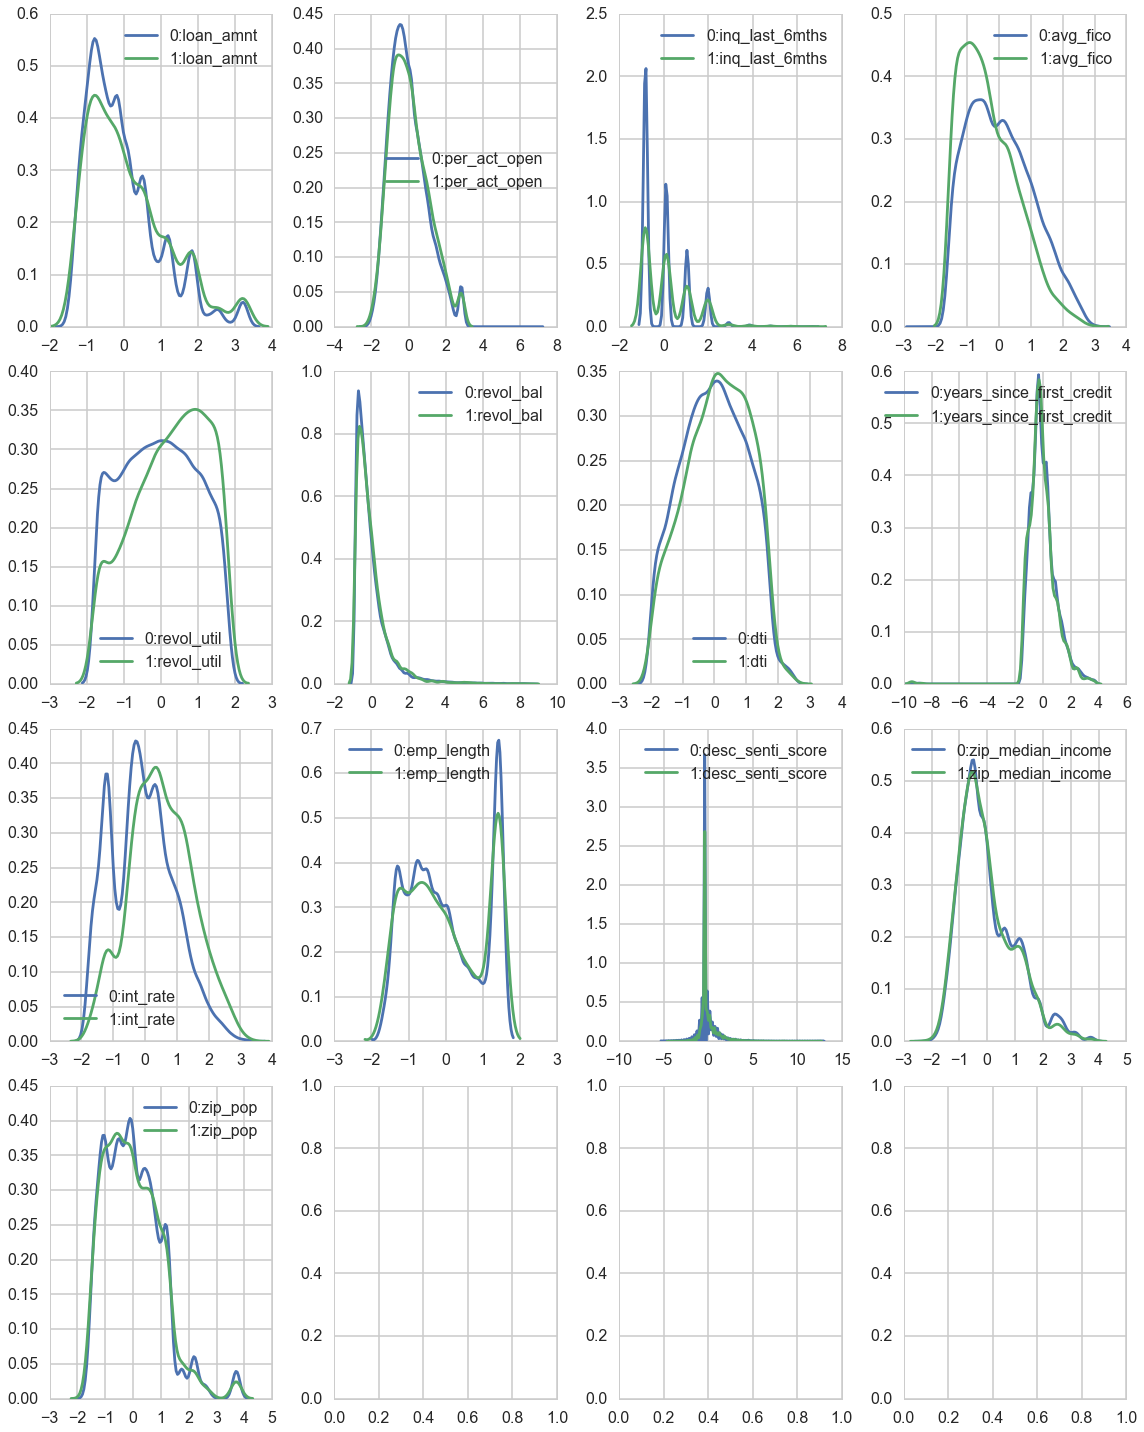

In [22]:
##### Kernel density estimate
#looking for features where the two line do not overlap much
df_grpby=full_df.groupby('loan_status')
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 20), 
                         tight_layout=True)
for ax, p in zip(axes.ravel(), predictors_standardizable):
    for k, v in df_grpby[p]:
        sns.kdeplot(v, ax=ax, label=str(k)+":"+v.name)

<b> Unfortuantely the standardized features all of them seam to overlap, none of them seem to be clear predictor<b>

/Users/ajaykliyara/anaconda_py3/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


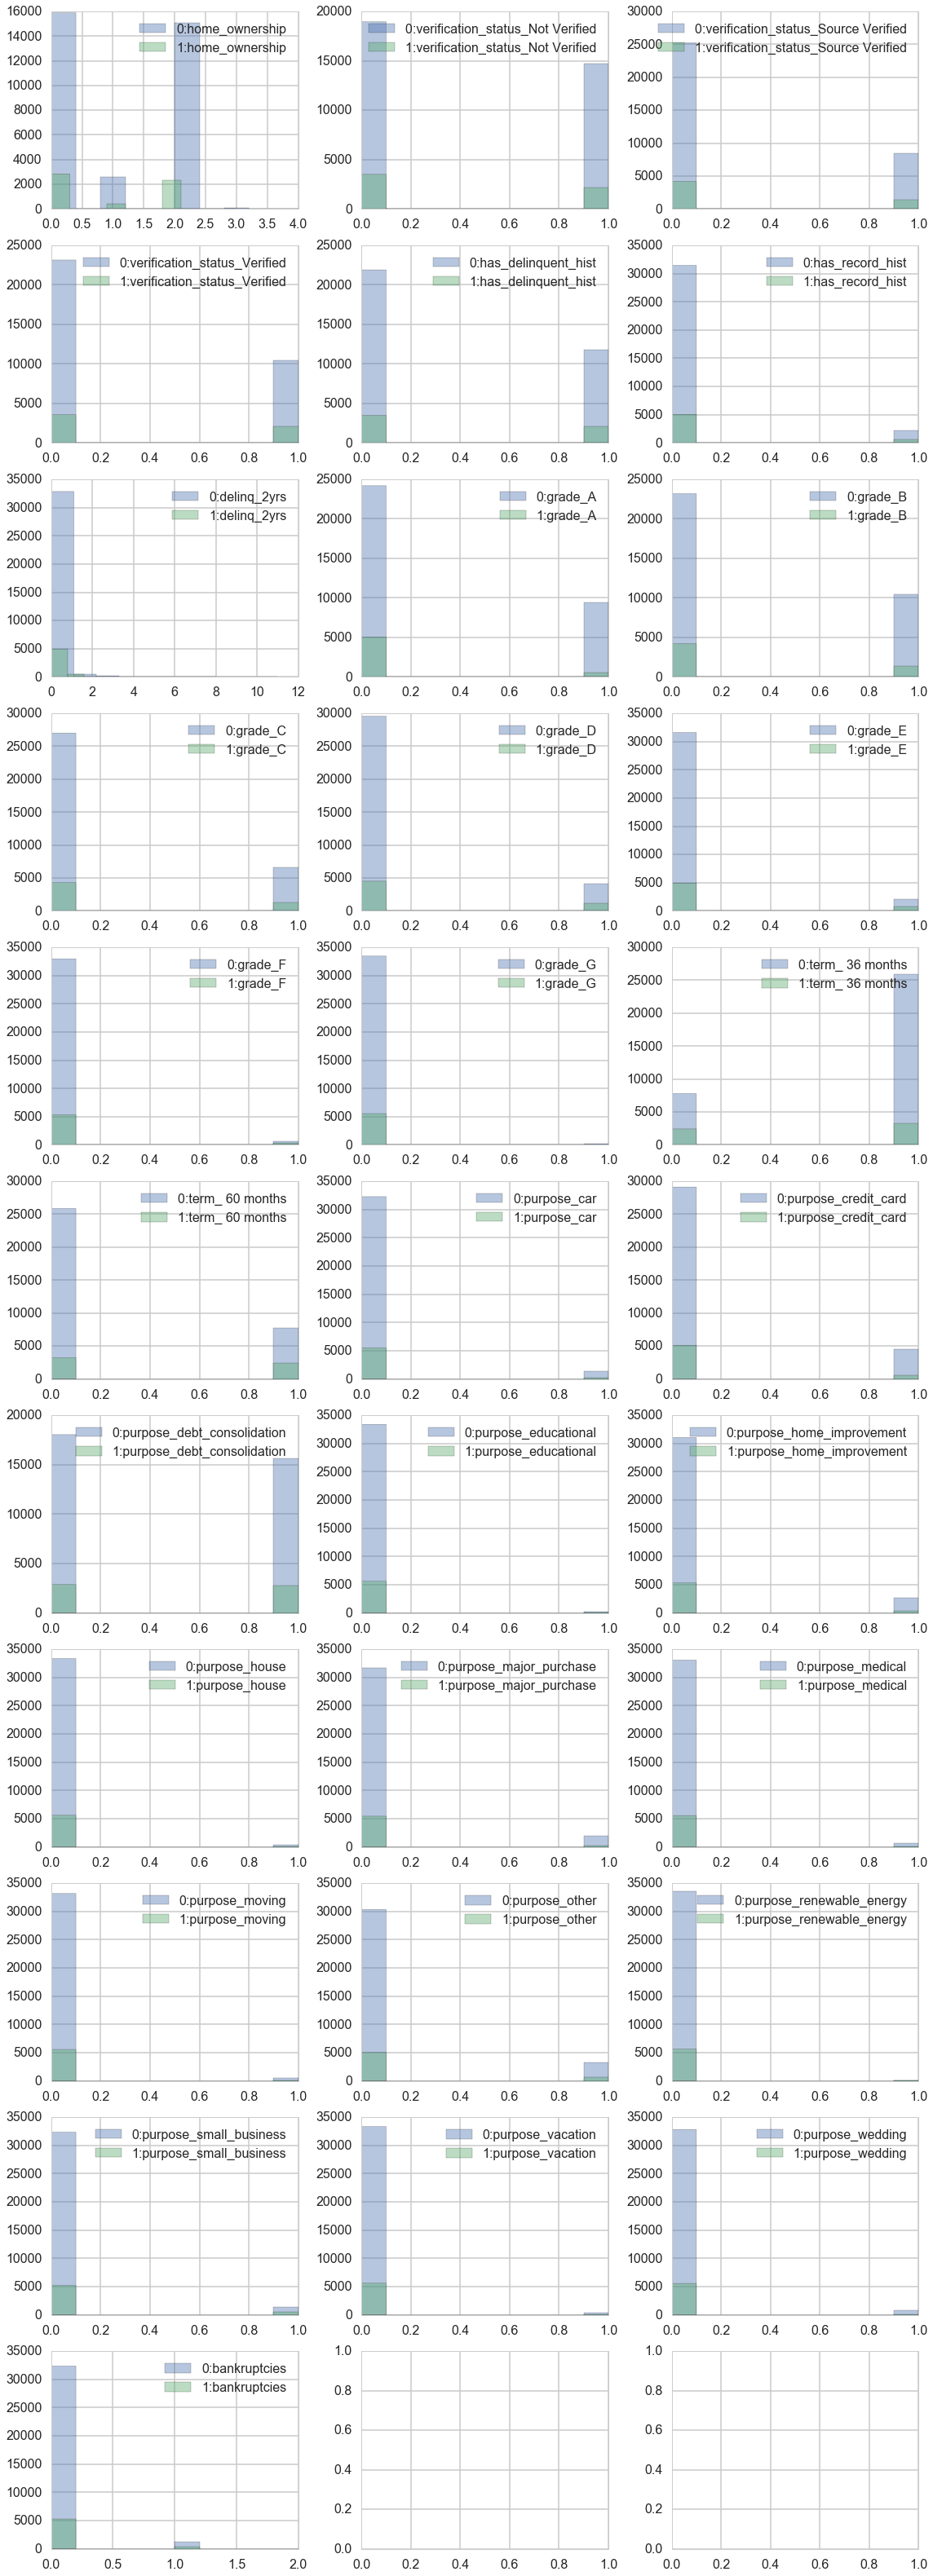

In [23]:
#histogram for indicator / discrete variables
#looking for bar which are exclusively belonging to one class
#your code here
df_grpby=full_df.groupby('loan_status')
fig, axes = plt.subplots(nrows=11, ncols=3, figsize=(16, 44), 
                         tight_layout=True)
for ax, p in zip(axes.ravel(), indicators):
    for k, v in df_grpby[p]:
        v.hist(ax=ax, alpha=0.4, label=str(k)+":"+v.name)
        ax.legend()

<b>Homeownership and term of 36 months seem to be relatively strong predictors of bad loans<b>

### Running Classifiers

#### Linear SVM

In [24]:
clf_svm=LinearSVC(loss="hinge")
C=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
X =full_df[predictor_columns]
Y =full_df['loan_status']

In [25]:
X_train=X[mask]
X_test=X[~mask]
Y_train=Y[mask]
Y_test=Y[~mask]

In [26]:

gs=GridSearchCV(clf_svm, param_grid={'C':C}, cv=5)
gs.fit(X_train, Y_train)
print("BEST", gs.best_params_, gs.best_score_, gs.grid_scores_)

BEST {'C': 0.001} 0.85572519084 [mean: 0.85573, std: 0.00006, params: {'C': 0.001}, mean: 0.85573, std: 0.00006, params: {'C': 0.01}, mean: 0.85573, std: 0.00006, params: {'C': 0.1}, mean: 0.85573, std: 0.00006, params: {'C': 1.0}, mean: 0.85573, std: 0.00006, params: {'C': 10.0}, mean: 0.72297, std: 0.13143, params: {'C': 100.0}]


/Users/ajaykliyara/anaconda_py3/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [27]:
#accuracy
best = gs.best_estimator_
best.fit(X_train, Y_train)
best.score(X_test, Y_test)

0.85726401492663895

In [28]:

'''

   Input
   -----
   X: Training Features
   Y_bin: Values Predicted binarized
   classifier_name: Name of classifier
   classifier: sklearn classifier init
   param_dict: dictionary of parameters to be passed to classifier
   scor_func: scoring method used
   no_cv: # of cvv
   
   Output
   ------
   training_time: training time in minutes
   best_estimator: best model after cvv
   best_params: best parameter 
   best_score: best score
   
'''

def perform_classify(X,Y,classifier_name,classifier,param_dict,scor_func,no_cv,mask=None, reuse_split=None):
    #training start time
    start_time = time.clock()
    clf = classifier
    parameters = param_dict
    fitmodel = GridSearchCV(clf, param_grid=parameters, cv=no_cv, scoring=scor_func)
    
    if mask != None:
        X_train, X_test, y_train, y_test = X[mask], X[~mask], Y[mask], Y[~mask]
        
    if reuse_split !=None:
        print("using reuse split")
        X_train, X_test, y_train, y_test = reuse_split['X_train'], reuse_split['X_test'], reuse_split['Y_train'], reuse_split['Y_test']
    
    fitmodel.fit(X_train,y_train)
    

    
    best_estimator = fitmodel.best_estimator_
    best_params = fitmodel.best_params_
    best_score = fitmodel.best_score_
    
    end_time = time.clock()
    training_time = (end_time - start_time)/60.0
    
    training_accuracy = best_estimator.score(X_train, y_train)
    test_accuracy = best_estimator.score(X_test, y_test)
    print("-------------- based on standard predict -----------------")
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    print("Accuracy on test data:     %0.2f" % (test_accuracy))
    print(confusion_matrix(y_test, best_estimator.predict(X_test)))
    print("-----------------------------------------------------------")
    
    print('{} Training Time : {} minutes'.format(classifier_name,training_time))
    print('{} Best Estimator \n {}'.format(classifier_name,best_estimator))
    print('{} Best Params \n {}'.format(classifier_name,best_params))
    print('{} Best {} \n {}'.format(classifier_name,'accuracy',best_score))##, fitmodel.grid_scores_
    
    
    return training_time,best_estimator,best_params,best_score
  

In [29]:
#parameters passed for Linear SVM
classifier_name = 'Linear SVM'
classifier = LinearSVC(loss="hinge")
param_dict = {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
no_cv = 5
scor_func = 'roc_auc'

In [30]:
#calling classifier on training set
lsvm_training_time,lsvm_best_estimator,lsvm_best_params,lsvm_best_score = perform_classify(X,Y,classifier_name,classifier,param_dict,scor_func,no_cv,mask=mask,reuse_split=None)

/Users/ajaykliyara/anaconda_py3/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:30: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


-------------- based on standard predict -----------------
Accuracy on training data: 0.81
Accuracy on test data:     0.81
[[9393  715]
 [1517  166]]
-----------------------------------------------------------
Linear SVM Training Time : 1.0995705666666666 minutes
Linear SVM Best Estimator 
 LinearSVC(C=100.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)
Linear SVM Best Params 
 {'C': 100.0}
Linear SVM Best accuracy 
 0.5722410175654065


### Esimating Costs

In [31]:
np.sum(~mask)

11791

In [32]:
#checking symmetry of data
1-Y.mean()

0.8561868654741609

<b> Data is highly assymetric, just predicting all loans as good will give an accuracy of 86%. Also linear SVM is not better than just predicting all as good loans will also give an accuracy of ~86% <b>

In [33]:
1-Y.mean()

0.8561868654741609

#### Determining Costs associated with TN, FN, FP, TP

<img src='images/confusionmatrix.png'></img>

In [34]:
#
confusion_matrix(Y_test, lsvm_best_estimator.predict(X_test))

array([[9393,  715],
       [1517,  166]])

<b>Our primary objective will be to maximize TP, therefore minizming FN. As FN would impact the lenders and they could potentially loose their investment</b>

#### True Negative

<b> TN (True Negative) are the good loans. The lenders only stand to gain from them. loss is 0 and gain corresponds to the interest  <b>

In [35]:
data_raw = pd.read_csv("data/loan_2007_2011.csv")

/Users/ajaykliyara/anaconda_py3/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [36]:
data_raw = data_raw.loc[data_raw.loan_status.isin(['Charged Off','Fully Paid']),:]

In [37]:
#computing true negative cost =  average interest gain per loan
tnc = -round(np.mean(data_raw.total_rec_int),0)
tnc

-2207.0

In [38]:
#computing false negative score = minus of average interest gain per loan
fnc = round(np.sum(data_raw.funded_amnt_inv - data_raw.total_rec_prncp)/Y.sum(),0)
fnc

3901.0

In [39]:
#computing true postive score = avg total principal that was lost + loss of interest

tpc = -round(np.sum(data_raw.funded_amnt_inv - data_raw.total_rec_prncp)/Y.sum(),0)

tpc

-3901.0

In [40]:
#computing false positive score, nothing gained
fpc = 0
fpc

0

In [42]:
#risk matrix
risk_matrix=np.array([[tnc, fpc],[fnc, tpc]])
risk_matrix

array([[-2207.,     0.],
       [ 3901., -3901.]])

In [43]:
#profit matrix
u = -risk_matrix
u

array([[ 2207.,    -0.],
       [-3901.,  3901.]])

<b> Basically we are penalizing bad loans classified as good, which have a very bad effect on lenders <b>

In [44]:
#calculating average profit per loan
def average_profit_pl(y, ypred, u):
    c=confusion_matrix(y,ypred)
    score=np.sum(c*u)/np.sum(c)
    return score

#### Establishing base classifiers based on Profit matrix

In [45]:
#predicting all loans as good
testsize = full_df[~mask].shape[0]
ypred_dste = np.zeros(testsize, dtype="int")
print(confusion_matrix(Y_test, ypred_dste))
dsteval=average_profit_pl(Y_test, ypred_dste, u)
dsteval

[[10108     0]
 [ 1683     0]]


1335.1686031719107

In [46]:
#predicting all as bad loans
ypred_ste = np.ones(testsize, dtype="int")
print(confusion_matrix(Y_test, ypred_ste))
steval = average_profit_pl(Y_test, ypred_ste, u)
steval

[[    0 10108]
 [    0  1683]]


556.81307777118138

<b> Thefore looks like predicting all loans as good is the one to beat<b>

In [58]:
profit_list = []
profit_dict = {'classifier':'Base Classifier:Predicting all loans = good','Profit Score': dsteval,'AUC': None,'Sensitivity':0}
profit_list.append(profit_dict)
pd.DataFrame(profit_list,columns=['classifier','Profit Score','AUC','Sensitivity'])

,classifier,Profit Score,AUC,Sensitivity
0,Base Classifier:Predicting all loans = good,1335.168603,None,0


In [ ]:
#now comparing against the linear svm result

In [47]:
average_profit_pl(Y_test, lsvm_best_estimator.predict(X_test), u)

1311.1780171317107

<b>Linear SVM performs same as baseline<b>

### Logistic Regression with Lasso Feature Selection

In [48]:
#parameters passed for Linear SVM
classifier_name = 'Logistic Regression with Lasso'
classifier = LogisticRegression(penalty="l1")
param_dict = {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
no_cv = 5
scor_func = 'roc_auc'


In [49]:
#calling classifier on training set
logL_training_time,logL_best_estimator,logL_best_params,logL_best_score = perform_classify(X,Y,classifier_name,classifier,param_dict,scor_func,no_cv,mask=mask,reuse_split=None)

/Users/ajaykliyara/anaconda_py3/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:30: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


-------------- based on standard predict -----------------
Accuracy on training data: 0.86
Accuracy on test data:     0.86
[[10086    22]
 [ 1667    16]]
-----------------------------------------------------------
Logistic Regression with Lasso Training Time : 1.1949325666666666 minutes
Logistic Regression with Lasso Best Estimator 
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Logistic Regression with Lasso Best Params 
 {'C': 1.0}
Logistic Regression with Lasso Best accuracy 
 0.6911804869794046


In [56]:
#profit 
profit_logl = average_profit_pl(Y_test, logL_best_estimator.predict(X_test), u)
profit_logl

1341.6377745738275

In [53]:
fpr_logl, tpr_logl, thresholds_logl = roc_curve(Y_test, logL_best_estimator.predict_proba(X_test)[:,1])
auc_logl = auc(fpr_logl,tpr_logl)
auc_logl


0.69229722443833586

In [61]:
log_cm = confusion_matrix(Y_test, logL_best_estimator.predict(X_test))
log_cm

array([[10086,    22],
       [ 1667,    16]])

In [65]:
logl_sen = round(log_cm[(1,1)]/(log_cm[(1,0)] + log_cm[(1,1)]),2)
logl_sen

0.01

In [66]:
profit_dict = {'classifier': classifier_name ,'Profit Score': profit_logl,'AUC': round(auc_logl,2),'Sensitivity':logl_sen}
profit_list.append(profit_dict)
pd.DataFrame(profit_list,columns=['classifier','Profit Score','AUC','Sensitivity'])

,classifier,Profit Score,AUC,Sensitivity
0,Base Classifier:Predicting all loans = good,1335.168603,NaN,0.00
1,Logistic Regression with Lasso,1341.637775,0.69,0.01


<b>Logistic Regression performs slightly better than baseline but sensititivy is still low <b>

In [ ]:
#Since this is a skewed dataset, manipulating threshold

In [67]:
def t_repredict(est,t, xtest):
    probs=est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred

In [68]:
u

array([[ 2207.,    -0.],
       [-3901.,  3901.]])

<b> As FN is more expensive than false positive, reducing the threshold from the standard sklearn threshold of 0.5 as by doing this , reduced threshold mean, chances of false positives are more than false negatives.<b>

In [69]:
# Standard threshold,0.5
average_profit_pl(Y_test, logL_best_estimator.predict(X_test), u)

1341.6377745738275

In [78]:
# threshold of 0.19

log_cm_mT = confusion_matrix(Y_test,t_repredict(logL_best_estimator, 0.19, X_test))
log_cm_mT

array([[7992, 2116],
       [ 891,  792]])

In [79]:
profit_log_mt = average_profit_pl(Y_test, t_repredict(logL_best_estimator, 0.19, X_test), u)
profit_log_mt

1463.1621575778136

In [80]:
log_mT_sen = round(log_cm_mT[(1,1)]/(log_cm_mT[(1,0)] + log_cm_mT[(1,1)]),2)
log_mT_sen

0.46999999999999997

In [81]:
profit_dict = {'classifier': 'Logistic with Lasso modified Threshold = 0.19' ,'Profit Score': profit_log_mt,'AUC': None,'Sensitivity':log_mT_sen}
profit_list.append(profit_dict)
pd.DataFrame(profit_list,columns=['classifier','Profit Score','AUC','Sensitivity'])

,classifier,Profit Score,AUC,Sensitivity
0,Base Classifier:Predicting all loans = good,1335.168603,NaN,0.00
1,Logistic Regression with Lasso,1341.637775,0.69,0.01
2,Logistic with Lasso modified Threshold = 0.19,1463.162158,NaN,0.47


<b> The optimum threshold was found to be at about 0.19, where profit becomes maximum <b>

In [72]:
x_axis = np.arange(0.5,0.05,-0.01)

In [73]:
 y_axis = [average_profit_pl(Y_test, t_repredict(logL_best_estimator, i, X_test), u) for i in x_axis]

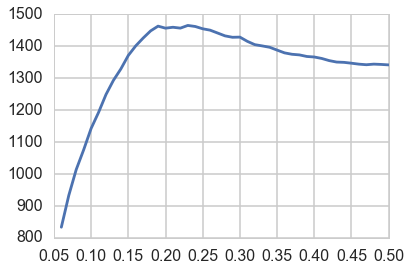

In [74]:
plt.plot(x_axis,y_axis)

In [86]:
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in range(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

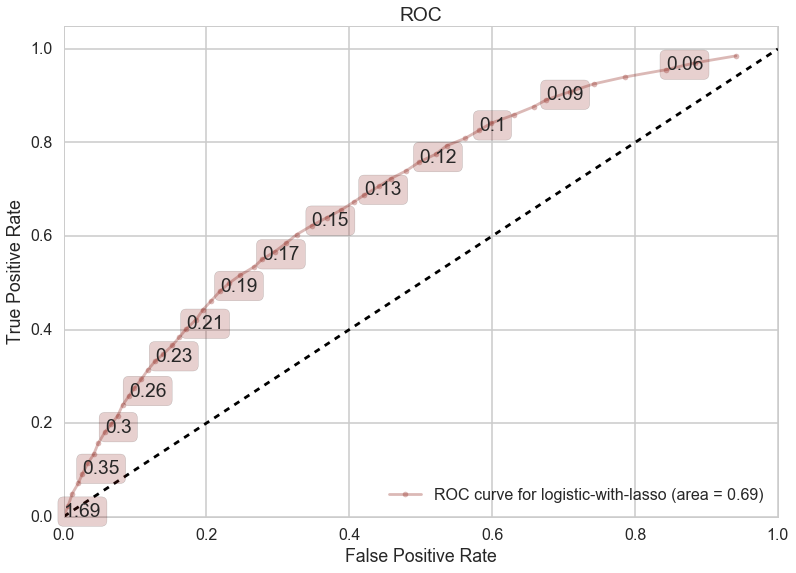

In [87]:
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("logistic-with-lasso",logL_best_estimator, Y_test, X_test, labe=200, skip=50)

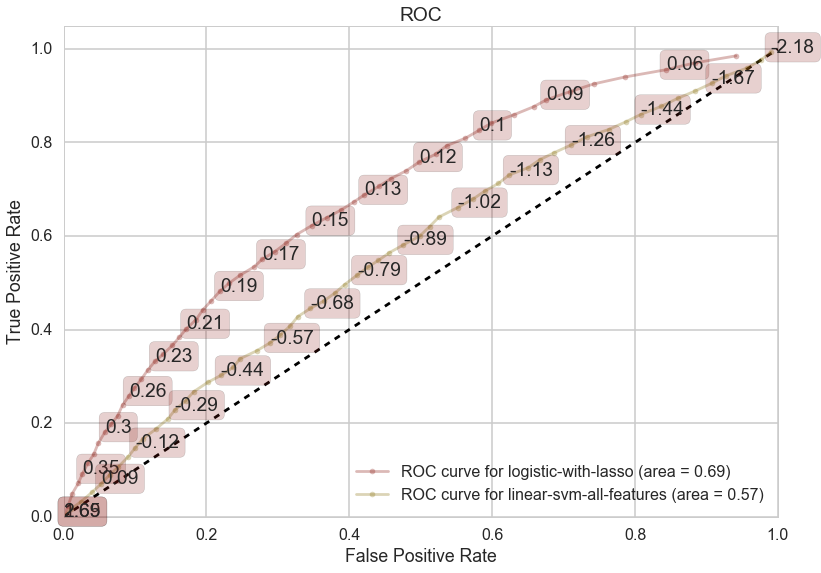

In [88]:
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("logistic-with-lasso",logL_best_estimator, Y_test, X_test, labe=200, skip=50)
    make_roc("linear-svm-all-features",lsvm_best_estimator, Y_test, X_test,ax, labe=200, proba=False, skip=50)

#### Feature Selection

#### Non Zero Lasso Features

In [89]:
def nonzero_lasso(clf):
    featuremask=(clf.coef_ !=0.0)[0]
    return pd.DataFrame(dict(feature=predictor_columns, coef=clf.coef_[0], abscoef=np.abs(clf.coef_[0])))[featuremask].sort_values(by='abscoef', ascending=False)

In [90]:
lasso_importances=nonzero_lasso(logL_best_estimator)
lasso_importances.set_index("feature", inplace=True)
lasso_importances.head(10)

,abscoef,coef
feature,,
grade_G,0.677433,-0.677433
purpose_small_business,0.664230,0.664230
term_ 36 months,0.599609,-0.599609
purpose_wedding,0.515891,-0.515891
has_record_hist,0.487348,0.487348
purpose_car,0.444470,-0.444470
int_rate,0.435818,0.435818
purpose_major_purchase,0.382399,-0.382399
purpose_credit_card,0.371284,-0.371284


#### Features importance using correlation

In [91]:
from scipy.stats.stats import pearsonr
correlations=[]
full_df_train=full_df[mask]
for col in predictor_columns:
    r=pearsonr(full_df_train[col], full_df_train['loan_status'])[0]
    correlations.append(dict(feature=col,corr=r, abscorr=np.abs(r)))

bpdf=pd.DataFrame(correlations).sort_values(by='abscorr', ascending=False)
bpdf.set_index(['feature'], inplace=True)
bpdf.head(25)

,abscorr,corr
feature,,
int_rate,0.203823,0.203823
term_ 60 months,0.156029,0.156029
term_ 36 months,0.156029,-0.156029
grade_A,0.140939,-0.140939
avg_fico,0.129425,-0.129425
revol_util,0.096093,0.096093
grade_E,0.091606,0.091606
purpose_small_business,0.080241,0.080241
grade_F,0.079697,0.079697


#### Pipeline : Feature select, standardize and train

#### Linear SVM with selected features

In [92]:
def pearson_scorer(X,y):
    rs=np.zeros(X.shape[1])
    pvals=np.zeros(X.shape[1])
    i=0
    for v in X.T:
        rs[i], pvals[i]=pearsonr(v, y)
        i=i+1
    return np.abs(rs), pvals    

In [93]:
#applying feature select on SVM which does not have built in feature selection
selectorlinearsvm = SelectKBest(k=25, score_func=pearson_scorer)
pipelinearsvm = Pipeline([('select', selectorlinearsvm), ('svm', LinearSVC(loss="hinge"))])

In [94]:
#parameters passed for Linear SVM
classifier_name = 'Linear SVM'
classifier = pipelinearsvm
param_dict = {"svm__C": [0.0001,0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
no_cv = 5
scor_func = 'accuracy'

In [95]:
#calling classifier on training set
pipelsvm_training_time,pipelsvm_best_estimator,pipelsvm_best_params,pipelsvm_best_score = perform_classify(X,Y,classifier_name,classifier,param_dict,scor_func,no_cv,mask=mask,reuse_split=None)

/Users/ajaykliyara/anaconda_py3/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:30: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


-------------- based on standard predict -----------------
Accuracy on training data: 0.86
Accuracy on test data:     0.86
[[10108     0]
 [ 1683     0]]
-----------------------------------------------------------
Linear SVM Training Time : 0.8323064500000001 minutes
Linear SVM Best Estimator 
 Pipeline(steps=[('select', SelectKBest(k=25, score_func=<function pearson_scorer at 0x129b82510>)), ('svm', LinearSVC(C=0.0001, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])
Linear SVM Best Params 
 {'svm__C': 0.0001}
Linear SVM Best accuracy 
 0.8557251908396947


In [72]:
np.array(predictor_columns)[pipelsvm_best_estimator.get_params()['select'].get_support()]

array(['verification_status_Not Verified', 'verification_status_Verified',
       'has_delinquent_hist', 'has_record_hist', 'loan_amnt',
       'inq_last_6mths', 'avg_fico', 'revol_util', 'dti', 'int_rate',
       'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F',
       'grade_G', 'term_ 36 months', 'term_ 60 months', 'purpose_car',
       'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_major_purchase', 'purpose_small_business', 'bankruptcies'], 
      dtype='<U35')

In [96]:
#profit 
profit_svml = average_profit_pl(Y_test, pipelsvm_best_estimator.predict(X_test), u)
profit_svml

1335.1686031719107

In [100]:
fpr_svml, tpr_svml, thresholds_svml = roc_curve(Y_test, pipelsvm_best_estimator.decision_function(X_test))
auc_svml = auc(fpr_svml,tpr_svml)
auc_svml

0.59234415666711582

In [102]:
svml_cm = confusion_matrix(Y_test, pipelsvm_best_estimator.predict(X_test))
svml_cm

array([[10108,     0],
       [ 1683,     0]])

In [103]:
svml_sen = round(svml_cm[(1,1)]/(svml_cm[(1,0)] + svml_cm[(1,1)]),2)
svml_sen

0.0

In [104]:
profit_dict = {'classifier': classifier_name ,'Profit Score': profit_svml,'AUC': round(auc_svml,2),'Sensitivity':svml_sen}
profit_list.append(profit_dict)
pd.DataFrame(profit_list,columns=['classifier','Profit Score','AUC','Sensitivity'])

,classifier,Profit Score,AUC,Sensitivity
0,Base Classifier:Predicting all loans = good,1335.168603,NaN,0.00
1,Logistic Regression with Lasso,1341.637775,0.69,0.01
2,Logistic with Lasso modified Threshold = 0.19,1463.162158,NaN,0.47
3,Linear SVM,1335.168603,0.59,0.00


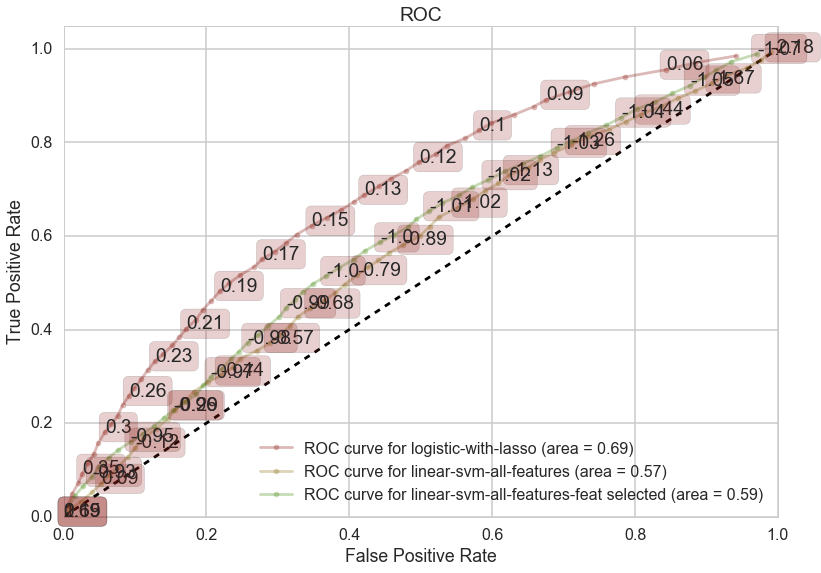

In [105]:
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("logistic-with-lasso",logL_best_estimator, Y_test, X_test, labe=200, skip=50)
    make_roc("linear-svm-all-features",lsvm_best_estimator, Y_test, X_test,ax, labe=200, proba=False, skip=50)
    make_roc("linear-svm-all-features-feat selected",pipelsvm_best_estimator, Y_test, X_test,ax, labe=200, proba=False, skip=50)

#### Balancing the dataset

In [106]:
jtrain=np.arange(0, Y_train.shape[0])
n_pos=len(jtrain[Y_train.values==1])
n_neg=len(jtrain[Y_train.values==0])
print(n_pos, n_neg)

3969 23541


In [107]:
jtrain[Y_train.values==0]

array([    0,     1,     2, ..., 27507, 27508, 27509])

In [108]:
ineg = np.random.choice(jtrain[Y_train.values==0], n_pos, replace=False)
ineg

array([ 5165, 17775, 10235, ..., 10647,  2513, 14744])

In [109]:
alli=np.concatenate((jtrain[Y_train.values==1], ineg))
alli.shape

(7938,)

In [110]:
alli

array([   14,    15,    23, ..., 10647,  2513, 14744])

In [111]:
X_train_new = X_train.iloc[alli,:]
Y_train_new = Y_train.iloc[alli]
X_train_new.shape, Y_train_new.shape

((7938, 44), (7938,))

In [112]:
reuse_split_new=dict(X_train=X_train_new, X_test=X_test, Y_train=Y_train_new, Y_test=Y_test)

#### Linear SVM with balanced set

In [113]:
#parameters passed for Linear SVM
classifier_name = 'Linear SVM - Balanced'
classifier = LinearSVC(loss="hinge")
param_dict = {"C": [0.00001,0.0001,0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
no_cv = 3
scor_func = 'roc_auc'

In [114]:
#calling classifier on training set
bal_lsvm_training_time,bal_lsvm_best_estimator,bal_lsvm_best_params,bal_lsvm_best_score = perform_classify(X,Y,classifier_name,classifier,param_dict,scor_func,no_cv,mask=None,reuse_split=reuse_split_new)

using reuse split
-------------- based on standard predict -----------------
Accuracy on training data: 0.61
Accuracy on test data:     0.60
[[5962 4146]
 [ 601 1082]]
-----------------------------------------------------------
Linear SVM - Balanced Training Time : 0.2194959000000002 minutes
Linear SVM - Balanced Best Estimator 
 LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)
Linear SVM - Balanced Best Params 
 {'C': 0.1}
Linear SVM - Balanced Best accuracy 
 0.6584973453562158


In [116]:
#profit 
profit_svmlb = average_profit_pl(Y_test, bal_lsvm_best_estimator.predict(X_test), u)
profit_svmlb

1275.0839623441609

In [124]:
fpr_svmlb, tpr_svmlb, thresholds_svmlb = roc_curve(Y_test, bal_lsvm_best_estimator.decision_function(X_test))
auc_svmlb = auc(fpr_svmlb,tpr_svmlb)
auc_svmlb

0.68035925022237564

In [118]:
svmlb_cm = confusion_matrix(Y_test, bal_lsvm_best_estimator.predict(X_test))
svmlb_cm

array([[5962, 4146],
       [ 601, 1082]])

In [119]:
svmlb_sen = round(svmlb_cm[(1,1)]/(svmlb_cm[(1,0)] + svmlb_cm[(1,1)]),2)
svmlb_sen

0.64000000000000001

In [126]:
profit_dict = {'classifier': classifier_name ,'Profit Score': profit_svmlb,'AUC': round(auc_svmlb,2),'Sensitivity':svmlb_sen}
profit_list.append(profit_dict)
pd.DataFrame(profit_list,columns=['classifier','Profit Score','AUC','Sensitivity'])

,classifier,Profit Score,AUC,Sensitivity
0,Base Classifier:Predicting all loans = good,1335.168603,NaN,0.00
1,Logistic Regression with Lasso,1341.637775,0.69,0.01
2,Logistic with Lasso modified Threshold = 0.19,1463.162158,NaN,0.47
3,Linear SVM,1335.168603,0.59,0.00
4,Linear SVM - Balanced,1275.083962,0.68,0.64


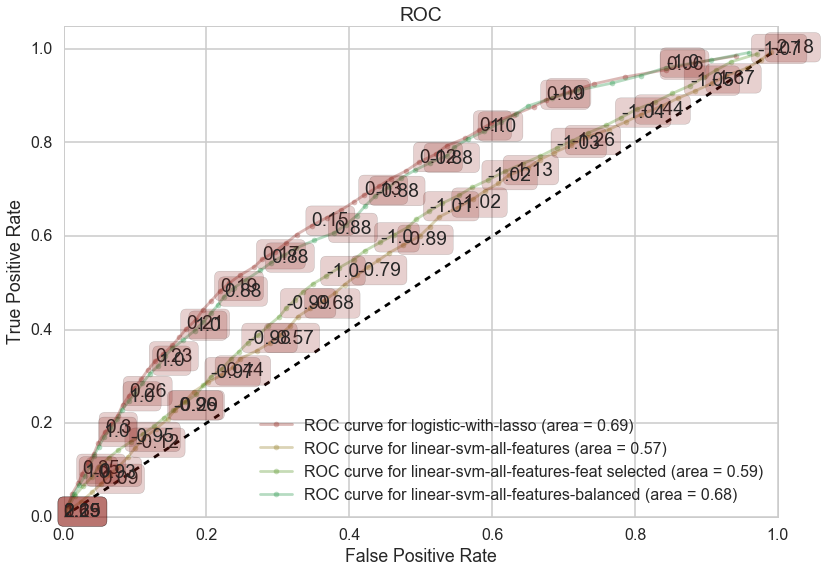

In [121]:
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("logistic-with-lasso",logL_best_estimator, Y_test, X_test, labe=200, skip=50)
    make_roc("linear-svm-all-features",lsvm_best_estimator, Y_test, X_test,ax, labe=200, proba=False, skip=50)
    make_roc("linear-svm-all-features-feat selected",pipelsvm_best_estimator, Y_test, X_test,ax, labe=200, proba=False, skip=50)
    make_roc("linear-svm-all-features-balanced",bal_lsvm_best_estimator, Y_test, X_test,ax, labe=200, proba=False, skip=50)

#### Logistic with balanced

In [127]:
#parameters passed for Linear SVM
classifier_name = 'Logistic Regression with Lasso - balanced'
classifier = LogisticRegression(penalty="l1")
param_dict = {"C": [0.0001,0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
no_cv = 5
scor_func = 'roc_auc'

In [128]:
#calling classifier on training set
bal_log_training_time,bal_log_best_estimator,bal_log_best_params,bal_log_best_score = perform_classify(X,Y,classifier_name,classifier,param_dict,scor_func,no_cv,mask=None,reuse_split=reuse_split_new)

using reuse split
-------------- based on standard predict -----------------
Accuracy on training data: 0.65
Accuracy on test data:     0.63
[[6288 3820]
 [ 581 1102]]
-----------------------------------------------------------
Logistic Regression with Lasso - balanced Training Time : 0.2100876999999997 minutes
Logistic Regression with Lasso - balanced Best Estimator 
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Logistic Regression with Lasso - balanced Best Params 
 {'C': 1.0}
Logistic Regression with Lasso - balanced Best accuracy 
 0.6722223334245192


In [129]:
#profit 
profit_logb = average_profit_pl(Y_test, bal_log_best_estimator.predict(X_test), u)
profit_logb

1349.3373759647188

In [130]:
fpr_loglb, tpr_loglb, thresholds_loglb = roc_curve(Y_test, bal_log_best_estimator.predict_proba(X_test)[:,1])
auc_loglb = auc(fpr_loglb,tpr_loglb)
auc_loglb

0.69189179911030974

In [132]:
logb_cm = confusion_matrix(Y_test, bal_log_best_estimator.predict(X_test))
logb_cm

array([[6288, 3820],
       [ 581, 1102]])

In [134]:
loglb_sen = round(logb_cm[(1,1)]/(logb_cm[(1,0)] + logb_cm[(1,1)]),2)
loglb_sen

0.65000000000000002

In [140]:
profit_dict = {'classifier': classifier_name ,'Profit Score': profit_logb,'AUC': round(auc_loglb,2),'Sensitivity':loglb_sen}
profit_list.append(profit_dict)
pd.DataFrame(profit_list,columns=['classifier','Profit Score','AUC','Sensitivity'])

,classifier,Profit Score,AUC,Sensitivity
0,Base Classifier:Predicting all loans = good,1335.168603,NaN,0.00
1,Logistic Regression with Lasso,1341.637775,0.69,0.01
2,Logistic with Lasso modified Threshold = 0.19,1463.162158,NaN,0.47
3,Linear SVM,1335.168603,0.59,0.00
4,Linear SVM - Balanced,1275.083962,0.68,0.64
5,Logistic Regression with Lasso - balanced,1349.337376,0.69,0.65


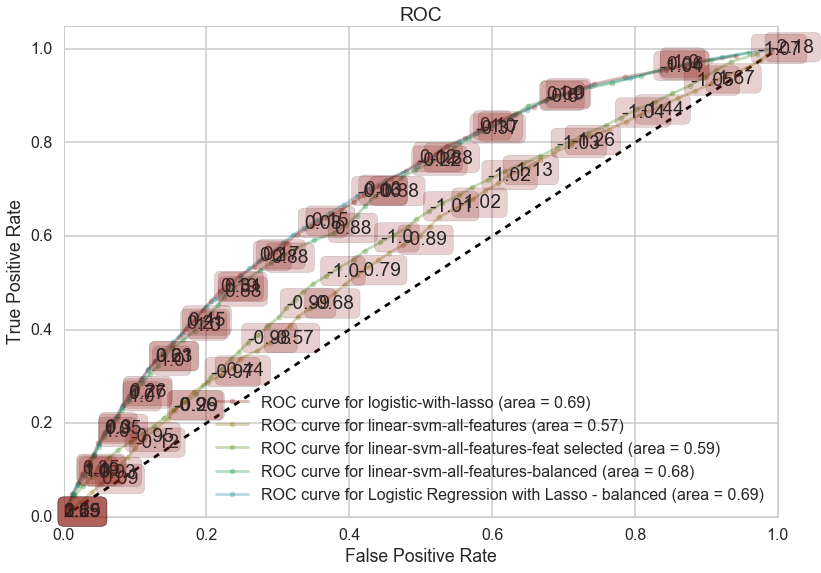

In [141]:
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("logistic-with-lasso",logL_best_estimator, Y_test, X_test, labe=200, skip=50)
    make_roc("linear-svm-all-features",lsvm_best_estimator, Y_test, X_test,ax, labe=200, proba=False, skip=50)
    make_roc("linear-svm-all-features-feat selected",pipelsvm_best_estimator, Y_test, X_test,ax, labe=200, proba=False, skip=50)
    make_roc("linear-svm-all-features-balanced",bal_lsvm_best_estimator, Y_test, X_test,ax, labe=200, proba=False, skip=50)
    make_roc("Logistic Regression with Lasso - balanced",bal_log_best_estimator, Y_test, X_test,ax, labe=200, proba=False, skip=50)

#### Decision Tree

In [142]:
#parameters passed for Logistic Regression
classifier_name = 'Decision Tree'
classifier = tree.DecisionTreeClassifier()
param_dict = {"criterion": ['gini','entropy'],
              'min_samples_split':[50,100],
              'splitter':['best','random']
             }
no_cv = 3
scor_func = 'roc_auc'

In [143]:
#calling classifier on training set
bal_dt_training_time,bal_dt_best_estimator,bal_dt_best_params,bal_dt_best_score = perform_classify(X,Y,classifier_name,classifier,param_dict,scor_func,no_cv,mask=None,reuse_split=reuse_split_new)

using reuse split
-------------- based on standard predict -----------------
Accuracy on training data: 0.69
Accuracy on test data:     0.59
[[5910 4198]
 [ 630 1053]]
-----------------------------------------------------------
Decision Tree Training Time : 0.02265971666666644 minutes
Decision Tree Best Estimator 
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=100, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='random')
Decision Tree Best Params 
 {'criterion': 'gini', 'splitter': 'random', 'min_samples_split': 100}
Decision Tree Best accuracy 
 0.6016559363030226


In [144]:
#profit 
average_profit_pl(Y_test, bal_dt_best_estimator.predict(X_test), u)

1246.1617335255703

#### Random Forest

In [145]:
#parameters passed for Logistic Regression
classifier_name = 'Random Forests'
classifier = RandomForestClassifier()
param_dict = {"criterion": ['gini','entropy'],'min_samples_split':[30,50,100],"n_estimators": [5,10,20,25,50,100]}
no_cv = 3
scor_func = 'accuracy'

In [146]:
#calling classifier on training set
bal_rf_training_time,bal_rf_best_estimator,bal_rf_best_params,bal_rf_best_score = perform_classify(X,Y,classifier_name,classifier,param_dict,scor_func,no_cv,mask=None,reuse_split=reuse_split_new)

using reuse split
-------------- based on standard predict -----------------
Accuracy on training data: 0.70
Accuracy on test data:     0.62
[[6234 3874]
 [ 599 1084]]
-----------------------------------------------------------
Random Forests Training Time : 0.5944593833333329 minutes
Random Forests Best Estimator 
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=100, min_weight_fraction_leaf=0.0,
            n_estimators=5, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Random Forests Best Params 
 {'n_estimators': 5, 'criterion': 'entropy', 'min_samples_split': 100}
Random Forests Best accuracy 
 0.5852859662383472


In [148]:
#profit 
profit_rf = average_profit_pl(Y_test, bal_rf_best_estimator.predict(X_test), u)
profit_rf

1327.3193961496056

In [149]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(Y_test, bal_rf_best_estimator.predict_proba(X_test)[:,1])
auc_rf = auc(fpr_rf,tpr_rf)
auc_rf

0.67653683650913565

In [150]:
rf_cm = confusion_matrix(Y_test, bal_rf_best_estimator.predict(X_test))
rf_cm

array([[6234, 3874],
       [ 599, 1084]])

In [151]:
rf_sen = round(rf_cm[(1,1)]/(rf_cm[(1,0)] + rf_cm[(1,1)]),2)
rf_sen

0.64000000000000001

In [152]:
profit_dict = {'classifier': classifier_name ,'Profit Score': profit_rf,'AUC': round(auc_rf,2),'Sensitivity':rf_sen}
profit_list.append(profit_dict)
pd.DataFrame(profit_list,columns=['classifier','Profit Score','AUC','Sensitivity'])

,classifier,Profit Score,AUC,Sensitivity
0,Base Classifier:Predicting all loans = good,1335.168603,NaN,0.00
1,Logistic Regression with Lasso,1341.637775,0.69,0.01
2,Logistic with Lasso modified Threshold = 0.19,1463.162158,NaN,0.47
3,Linear SVM,1335.168603,0.59,0.00
4,Linear SVM - Balanced,1275.083962,0.68,0.64
5,Logistic Regression with Lasso - balanced,1349.337376,0.69,0.65
6,Random Forests,1327.319396,0.68,0.64


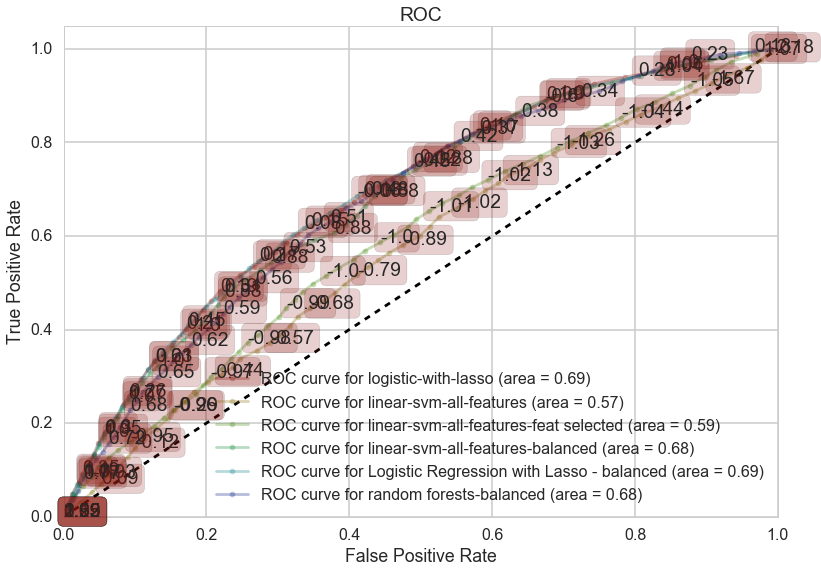

In [153]:
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("logistic-with-lasso",logL_best_estimator, Y_test, X_test, labe=200, skip=50)
    make_roc("linear-svm-all-features",lsvm_best_estimator, Y_test, X_test,ax, labe=200, proba=False, skip=50)
    make_roc("linear-svm-all-features-feat selected",pipelsvm_best_estimator, Y_test, X_test,ax, labe=200, proba=False, skip=50)
    make_roc("linear-svm-all-features-balanced",bal_lsvm_best_estimator, Y_test, X_test,ax, labe=200, proba=False, skip=50)
    make_roc("Logistic Regression with Lasso - balanced",bal_log_best_estimator, Y_test, X_test,ax, labe=200, proba=False, skip=50)
    make_roc("random forests-balanced",bal_rf_best_estimator, Y_test, X_test,ax, labe=200, proba=True, skip=50)

##### Best Classifier trained on the whole set

In [154]:
clf_rf_cvv = RandomForestClassifier(criterion=bal_rf_best_params['criterion'],min_samples_split=bal_rf_best_params['min_samples_split'],n_estimators=bal_rf_best_params['n_estimators'])

In [155]:
#training whole data
clf_rf_cvv.fit(X_train_new, Y_train_new)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=100, min_weight_fraction_leaf=0.0,
            n_estimators=5, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [156]:
y_predict_rf = clf_rf_cvv.predict(X_test)

In [157]:
np.mean(Y_test==y_predict_rf)

0.61055041981172076

In [158]:
confusion_matrix(Y_test,y_predict_rf)

array([[6106, 4002],
       [ 590, 1093]])

In [159]:
#profit 
average_profit_pl(Y_test, clf_rf_cvv.predict(X_test), u)

1309.3160037316597

In [160]:
fpr_rf, tpr_rf, thresholds_rf=roc_curve(Y_test, clf_rf_cvv.predict_proba(X_test)[:,1])

In [161]:
auc(fpr_rf,tpr_rf)

0.67235681731771024

In [162]:
cols = list(X_test.columns)

In [163]:
importances = bal_rf_best_estimator.feature_importances_
std = np.std([tree.feature_importances_ for tree in bal_rf_best_estimator.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_test.shape[1]):
    print("%d. %s (%f)" % (f + 1, cols[f], importances[indices[f]]))

Feature ranking:
1. home_ownership (0.125179)
2. verification_status_Not Verified (0.070658)
3. verification_status_Source Verified (0.066943)
4. verification_status_Verified (0.062893)
5. has_delinquent_hist (0.059173)
6. has_record_hist (0.058124)
7. loan_amnt (0.054604)
8. per_act_open (0.052950)
9. inq_last_6mths (0.046931)
10. avg_fico (0.041125)
11. revol_util (0.040405)
12. revol_bal (0.039170)
13. dti (0.037908)
14. years_since_first_credit (0.029749)
15. int_rate (0.027183)
16. emp_length (0.024652)
17. desc_senti_score (0.022261)
18. zip_median_income (0.014504)
19. zip_pop (0.013000)
20. delinq_2yrs (0.012839)
21. grade_A (0.010653)
22. grade_B (0.009578)
23. grade_C (0.008915)
24. grade_D (0.008401)
25. grade_E (0.006837)
26. grade_F (0.005171)
27. grade_G (0.005130)
28. term_ 36 months (0.004960)
29. term_ 60 months (0.004798)
30. purpose_car (0.004662)
31. purpose_credit_card (0.004561)
32. purpose_debt_consolidation (0.003660)
33. purpose_educational (0.003104)
34. purpo

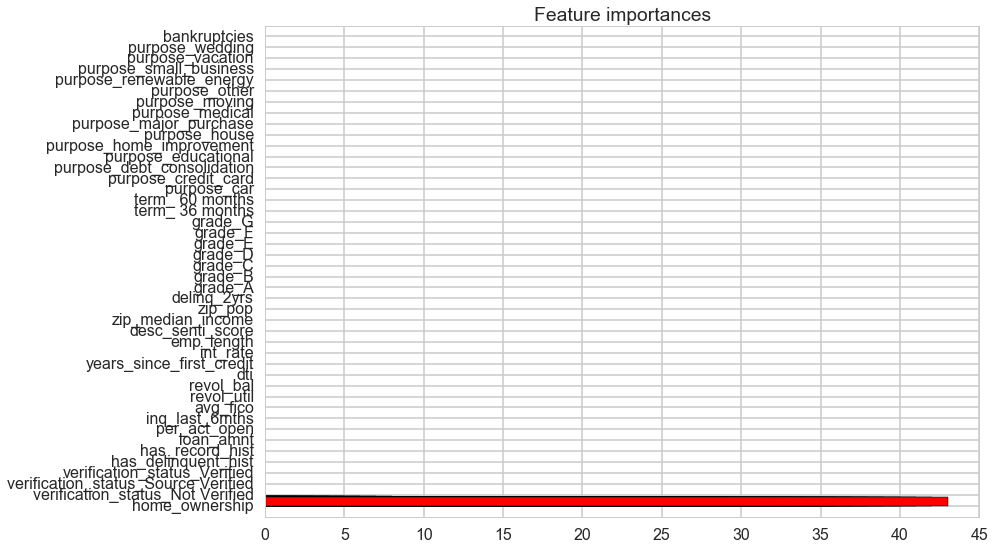

In [175]:
#http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh( importances[indices], range(X_test.shape[1]),
       color="r")
plt.yticks(range(X_test.shape[1]), cols)
plt.ylim([-1, X_test.shape[1]])
plt.show()

#### Naive Bayes

In [176]:
#parameters passed for Logistic Regression
classifier_name = 'Naive Bayes'
classifier = GaussianNB()
param_dict = {}
no_cv = 2
scor_func = 'roc_auc'

In [177]:
#calling classifier on training set
bal_nb_training_time,bal_nb_best_estimator,bal_nb_best_params,bal_nb_best_score = perform_classify(X,Y,classifier_name,classifier,param_dict,scor_func,no_cv,mask=None,reuse_split=reuse_split_new)

using reuse split
-------------- based on standard predict -----------------
Accuracy on training data: 0.63
Accuracy on test data:     0.66
[[6883 3225]
 [ 763  920]]
-----------------------------------------------------------
Naive Bayes Training Time : 0.0010742666666667825 minutes
Naive Bayes Best Estimator 
 GaussianNB(priors=None)
Naive Bayes Best Params 
 {}
Naive Bayes Best accuracy 
 0.6567477979299965


In [181]:
#profit 
profit_nb = average_profit_pl(Y_test, bal_nb_best_estimator.predict(X_test), u)
profit_nb

1340.2797048596387

In [182]:
fpr_nb, tpr_nb, thresholds_nb = roc_curve(Y_test, bal_nb_best_estimator.predict_proba(X_test)[:,1])
auc_nb = auc(fpr_nb,tpr_nb)
auc_nb

0.65205859897891838

In [183]:
nb_cm = confusion_matrix(Y_test, bal_nb_best_estimator.predict(X_test))
nb_cm

array([[6883, 3225],
       [ 763,  920]])

In [185]:
nb_sen = round(nb_cm[(1,1)]/(nb_cm[(1,0)] + nb_cm[(1,1)]),2)
nb_sen

0.55000000000000004

In [187]:
profit_dict = {'classifier': classifier_name ,'Profit Score': profit_nb,'AUC': round(auc_nb,2),'Sensitivity':nb_sen}
profit_list.append(profit_dict)
pd.DataFrame(profit_list,columns=['classifier','Profit Score','AUC','Sensitivity'])

,classifier,Profit Score,AUC,Sensitivity
0,Base Classifier:Predicting all loans = good,1335.168603,NaN,0.00
1,Logistic Regression with Lasso,1341.637775,0.69,0.01
2,Logistic with Lasso modified Threshold = 0.19,1463.162158,NaN,0.47
3,Linear SVM,1335.168603,0.59,0.00
4,Linear SVM - Balanced,1275.083962,0.68,0.64
5,Logistic Regression with Lasso - balanced,1349.337376,0.69,0.65
6,Random Forests,1327.319396,0.68,0.64
7,Naive Bayes,1340.279705,0.65,0.55


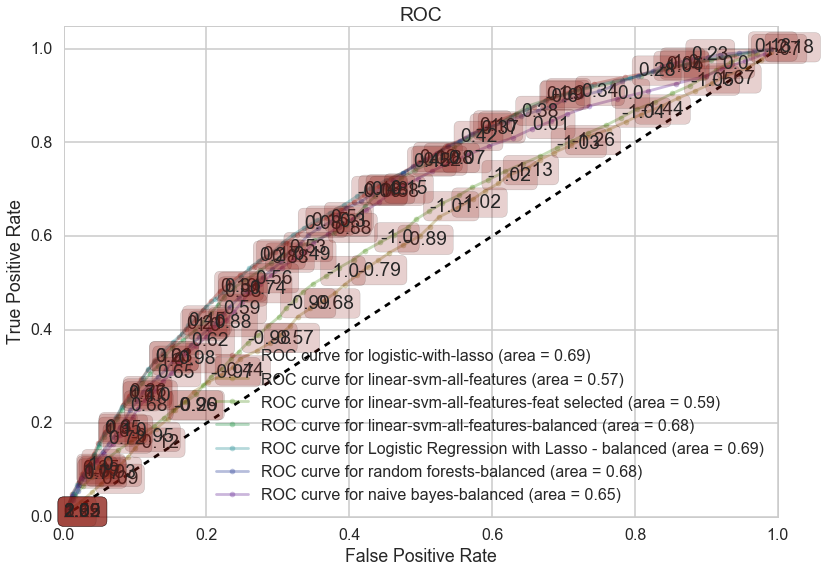

In [189]:
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("logistic-with-lasso",logL_best_estimator, Y_test, X_test, labe=200, skip=50)
    make_roc("linear-svm-all-features",lsvm_best_estimator, Y_test, X_test,ax, labe=200, proba=False, skip=50)
    make_roc("linear-svm-all-features-feat selected",pipelsvm_best_estimator, Y_test, X_test,ax, labe=200, proba=False, skip=50)
    make_roc("linear-svm-all-features-balanced",bal_lsvm_best_estimator, Y_test, X_test,ax, labe=200, proba=False, skip=50)
    make_roc("Logistic Regression with Lasso - balanced",bal_log_best_estimator, Y_test, X_test,ax, labe=200, proba=False, skip=50)
    make_roc("random forests-balanced",bal_rf_best_estimator, Y_test, X_test,ax, labe=200, proba=True, skip=50)
    make_roc("naive bayes-balanced",bal_nb_best_estimator, Y_test, X_test,ax, labe=200, proba=True, skip=50)
    

In [188]:
final_scores = pd.DataFrame(profit_list,columns=['classifier','Profit Score','AUC','Sensitivity'])
final_scores

,classifier,Profit Score,AUC,Sensitivity
0,Base Classifier:Predicting all loans = good,1335.168603,NaN,0.00
1,Logistic Regression with Lasso,1341.637775,0.69,0.01
2,Logistic with Lasso modified Threshold = 0.19,1463.162158,NaN,0.47
3,Linear SVM,1335.168603,0.59,0.00
4,Linear SVM - Balanced,1275.083962,0.68,0.64
5,Logistic Regression with Lasso - balanced,1349.337376,0.69,0.65
6,Random Forests,1327.319396,0.68,0.64
7,Naive Bayes,1340.279705,0.65,0.55


In [ ]:
#Final ROC eliminating Weak Classifiers

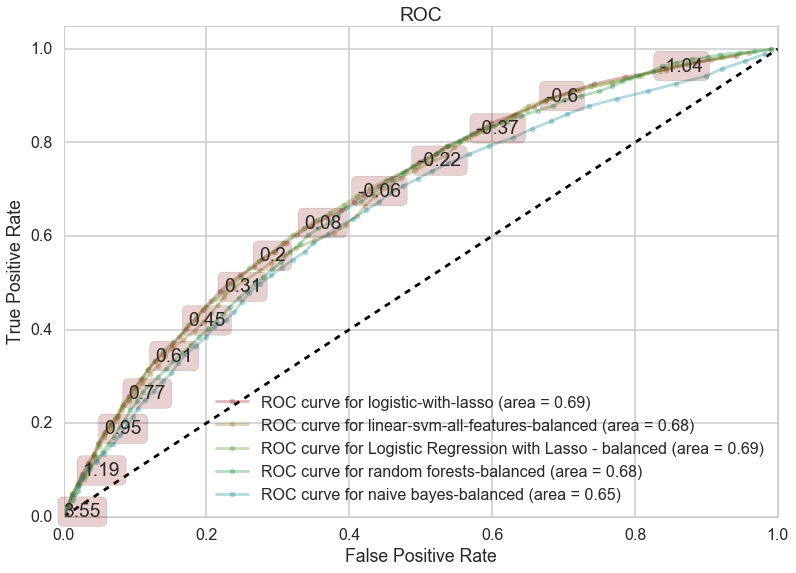

In [194]:
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("logistic-with-lasso",logL_best_estimator, Y_test, X_test, labe=None, skip=50)
    make_roc("linear-svm-all-features-balanced",bal_lsvm_best_estimator, Y_test, X_test,ax, labe=None, proba=False, skip=50)
    make_roc("Logistic Regression with Lasso - balanced",bal_log_best_estimator, Y_test, X_test,ax, labe=200, proba=False, skip=50)
    make_roc("random forests-balanced",bal_rf_best_estimator, Y_test, X_test,ax, labe=None, proba=True, skip=50)
    make_roc("naive bayes-balanced",bal_nb_best_estimator, Y_test, X_test,ax, labe=None, proba=True, skip=50)
    

In [205]:
#exporting best classifier to pickle

#joblib.dump(clf, 'filename.pkl') 

In [196]:
clf = LogisticRegression(C=1,penalty="l1")
clf

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [197]:
clf.fit(X_train_new,Y_train_new)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [200]:
clf.score(X_train_new,Y_train_new)

0.64890400604686316

In [201]:
X_train.columns

Index(['home_ownership', 'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified',
       'has_delinquent_hist', 'has_record_hist', 'loan_amnt', 'per_act_open',
       'inq_last_6mths', 'avg_fico', 'revol_util', 'revol_bal', 'dti',
       'years_since_first_credit', 'int_rate', 'emp_length',
       'desc_senti_score', 'zip_median_income', 'zip_pop', 'delinq_2yrs',
       'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F',
       'grade_G', 'term_ 36 months', 'term_ 60 months', 'purpose_car',
       'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'bankruptcies'],
      dtype='object')

In [ ]:
from sklearn.externals import joblib
joblib.dump(clf, 'filename.pkl') 

In [ ]:
clf = joblib.load('filename.pkl') 